<a href="https://colab.research.google.com/github/isaacmedina/machinelearning/blob/main/impago_prestamo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de impago de préstamos

#Enunciado
La entidad “FinCredit” desea un sistema de scoring que prevea la probabilidad de impago de los solicitantes de préstamo personales. Se suministra un histórico de 150 000 clientes con variables socioeconómicas y comportamentales. El objetivo (SeriousDlqin2yrs) es binario y altamente desbalanceado (~6 % impagos). Tu tarea es diseñar un proceso de limpieza y preparación que maximice la robustez del modelo y documente cada decisión.


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np

#Dataset
Give Me Some Credit — disponible públicamente en Kaggle o GitHub

In [19]:
url = "https://raw.githubusercontent.com/JLZml/Credit-Scoring-Data-Sets/master/3.%20Kaggle/Give%20Me%20Some%20Credit/cs-training.csv"
df = pd.read_csv(url)

#Inspección rápida

In [20]:
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


#1. Análisis EDA




1.1.   Estadísticas Generales



In [21]:
df.describe().round(2)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.00,150000.00,150000.00,150000.00,150000.00,150000.00,120269.00,150000.00,150000.00,150000.00,150000.00,146076.00
mean,75000.50,0.07,6.05,52.30,0.42,353.01,6670.22,8.45,0.27,1.02,0.24,0.76
std,43301.41,0.25,249.76,14.77,4.19,2037.82,14384.67,5.15,4.17,1.13,4.16,1.12
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,37500.75,0.00,0.03,41.00,0.00,0.18,3400.00,5.00,0.00,0.00,0.00,0.00
50%,75000.50,0.00,0.15,52.00,0.00,0.37,5400.00,8.00,0.00,1.00,0.00,0.00
75%,112500.25,0.00,0.56,63.00,0.00,0.87,8249.00,11.00,0.00,2.00,0.00,1.00
max,150000.00,1.00,50708.00,109.00,98.00,329664.00,3008750.00,58.00,98.00,54.00,98.00,20.00


In [22]:
df_imp = df[df['SeriousDlqin2yrs'] == 1]
df_imp.describe().round(2)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,10026.00,10026.0,10026.00,10026.00,10026.00,10026.00,8357.00,10026.00,10026.00,10026.00,10026.00,9847.00
mean,75453.64,1.0,4.37,45.93,2.39,295.12,5630.83,7.88,2.09,0.99,1.83,0.95
std,43349.99,0.0,131.84,12.92,11.73,1238.36,6171.72,5.65,11.76,1.43,11.75,1.22
min,1.00,1.0,0.00,21.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,38257.25,1.0,0.40,36.00,0.00,0.19,2963.00,4.00,0.00,0.00,0.00,0.00
50%,75283.00,1.0,0.84,45.00,0.00,0.43,4500.00,7.00,0.00,1.00,0.00,0.00
75%,112962.00,1.0,1.00,54.00,2.00,0.89,6800.00,11.00,1.00,2.00,1.00,2.00
max,149980.00,1.0,8328.00,101.00,98.00,38793.00,250000.00,57.00,98.00,29.00,98.00,8.00




1.2.   Matriz de Correlación



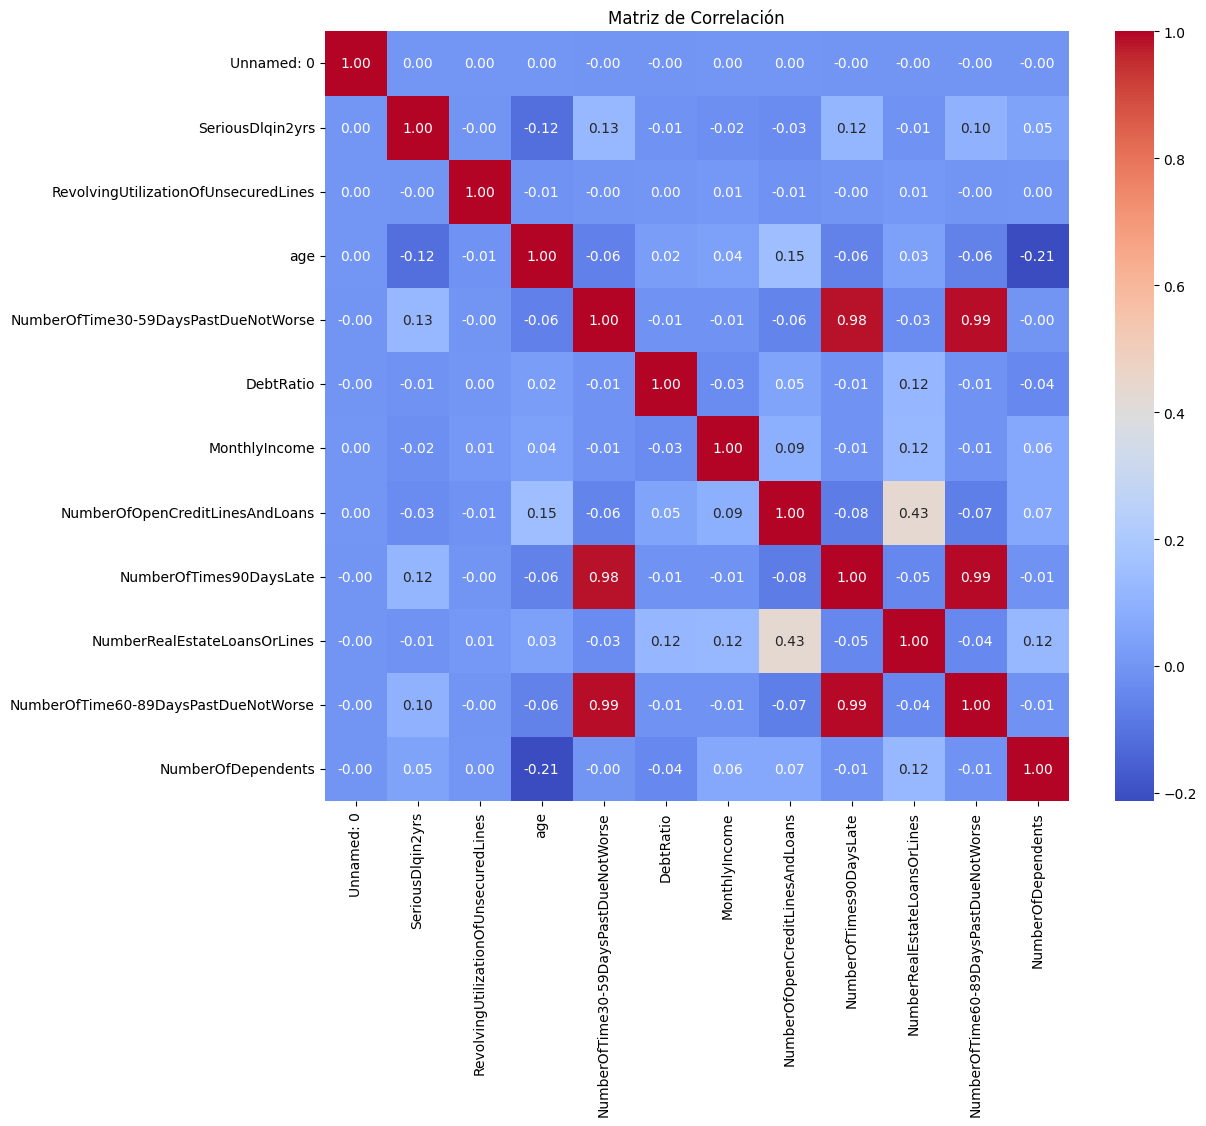

In [23]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

1.2.1 Matriz de correlación para casos de impago.

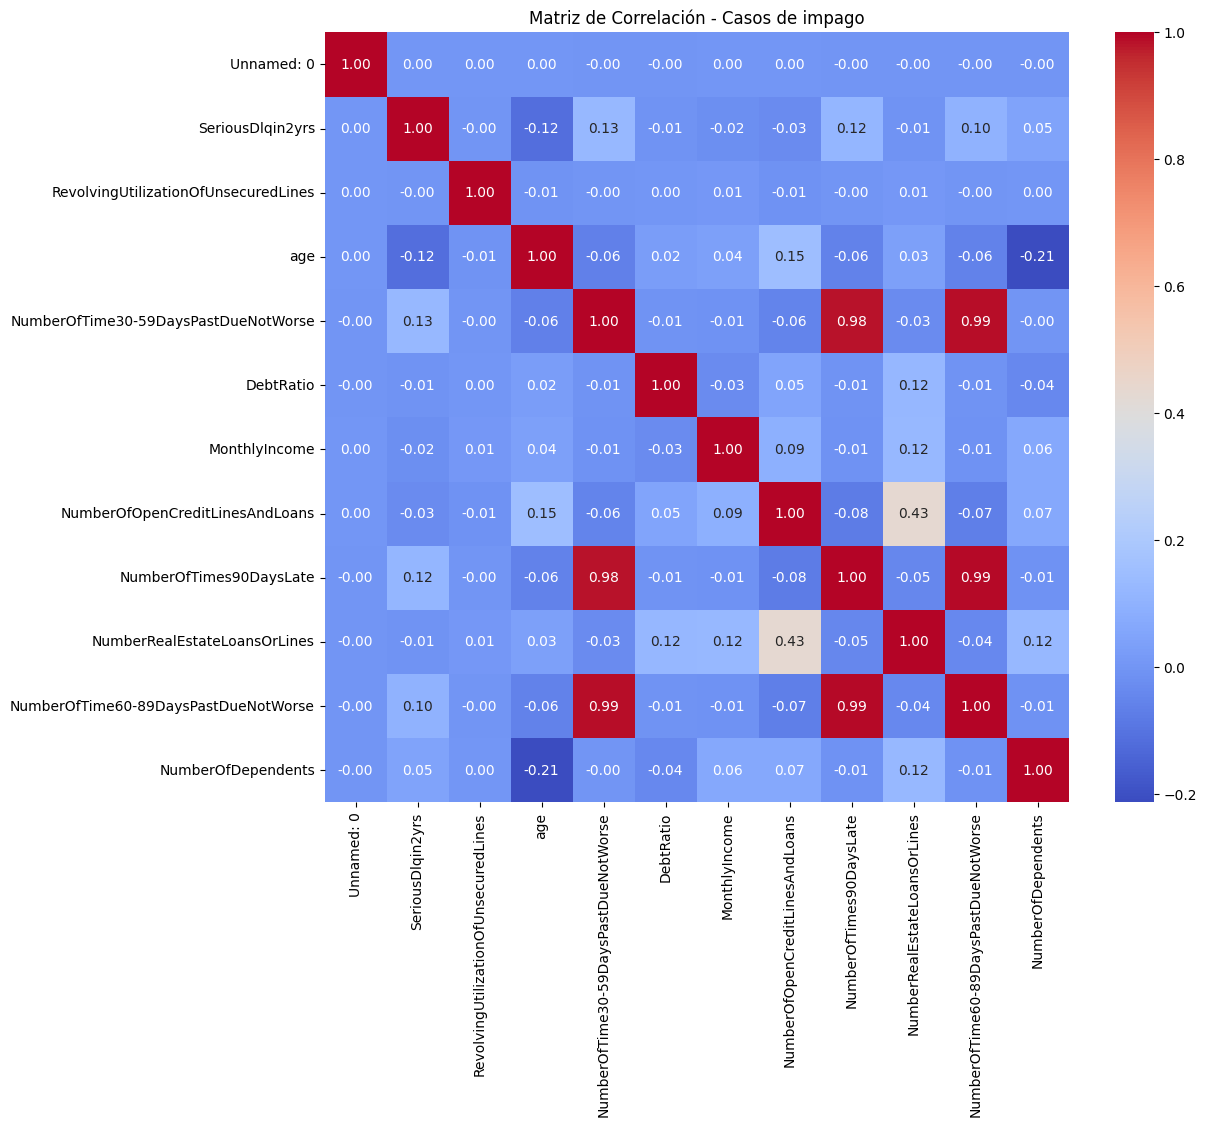

In [24]:

correlation_matrix_imp = df_imp.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación - Casos de impago')
plt.show()

1.3 Análisis de distribución por clase

<Axes: xlabel='SeriousDlqin2yrs', ylabel='count'>

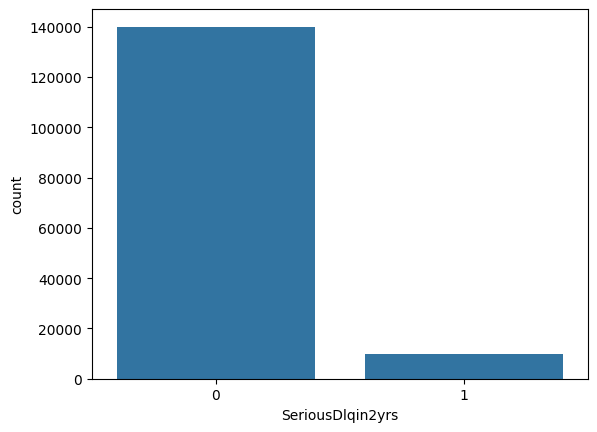

In [25]:
sns.countplot(x='SeriousDlqin2yrs', data=df)

1.4 Análisis Cruzado - Porcentaje del recuento de cada combinación

In [26]:
pd.crosstab(df['NumberOfDependents'], df['SeriousDlqin2yrs'], normalize='index')

SeriousDlqin2yrs,0,1
NumberOfDependents,,
0.0,0.941371,0.058629
1.0,0.926471,0.073529
2.0,0.918861,0.081139
3.0,0.911737,0.088263
4.0,0.896226,0.103774
5.0,0.908847,0.091153
6.0,0.848101,0.151899
7.0,0.901961,0.098039
8.0,0.916667,0.083333


# Distribuciones numéricas por clase

In [27]:
target_col = 'SeriousDlqin2yrs'
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Unnamed: 0' in num_cols:
    num_cols.remove('Unnamed: 0')
if target_col in num_cols:
    num_cols.remove(target_col)


Histogramas de algunas variables clave

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


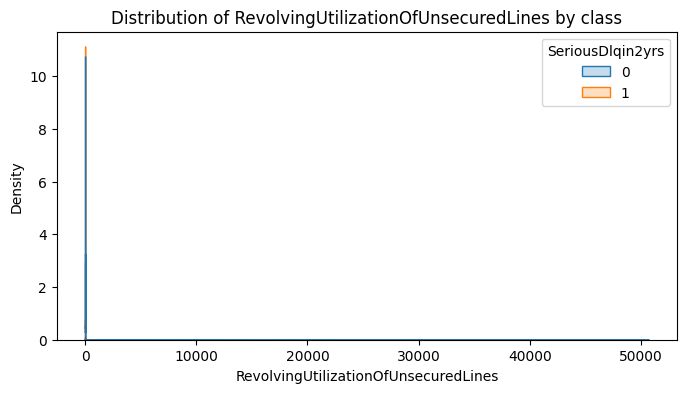

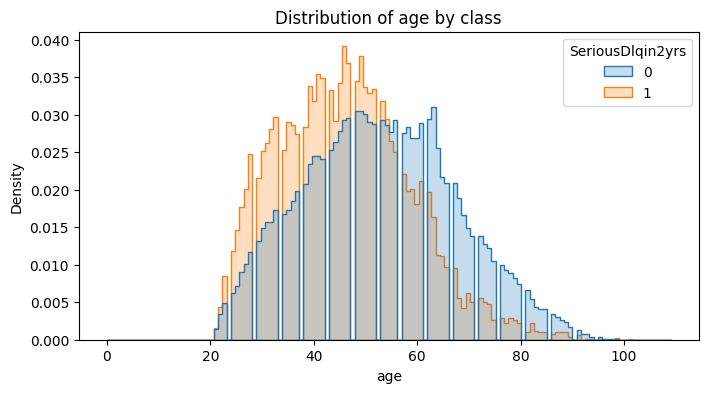

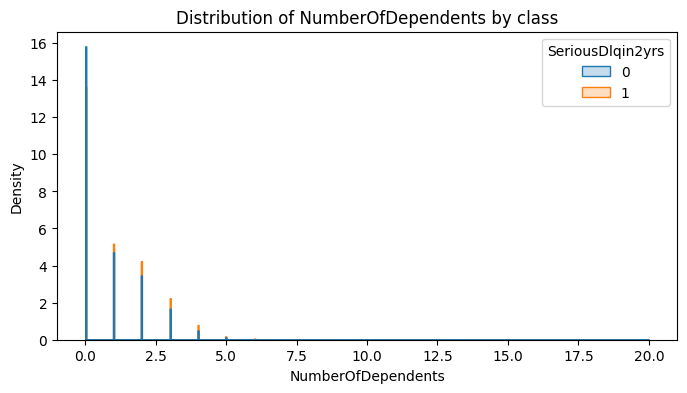

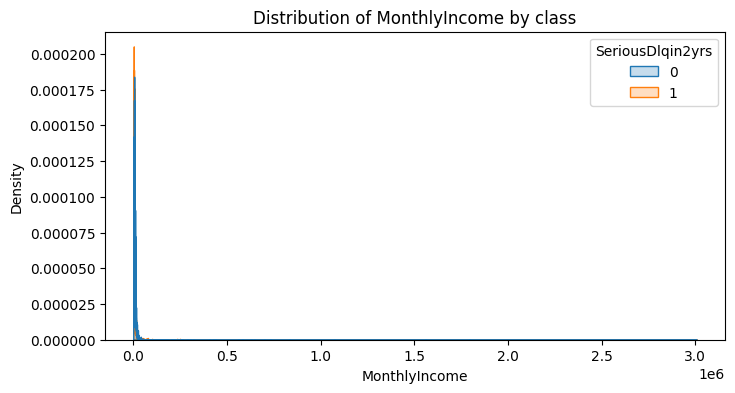

In [47]:
sample_cols = ['RevolvingUtilizationOfUnsecuredLines','age','NumberOfDependents','MonthlyIncome']
for col in sample_cols:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        sns.histplot(data=df, x=col, hue=target_col, stat='density', element='step', common_norm=False)
        plt.title(f'Distribution of {col} by class')
        plt.show()

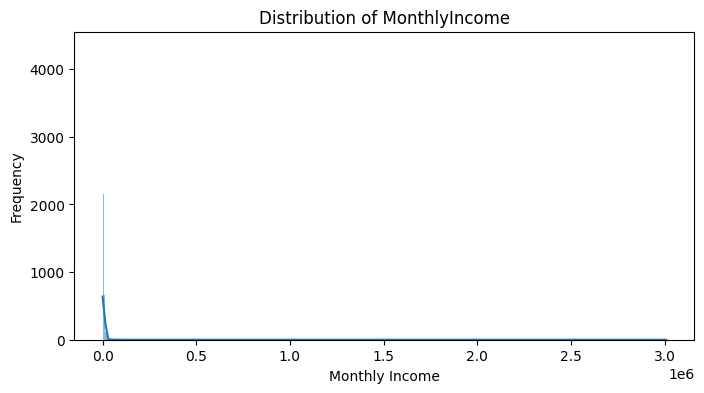

In [46]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='MonthlyIncome', kde=True)
plt.title('Distribution of MonthlyIncome')
plt.xlabel('Monthly Income')
plt.ylabel('Frequency')
plt.show()

# Tratamiento de valores faltantes

Columnas con mayor porcentaje de missing values

In [29]:
missing_pct = df.isnull().mean().sort_values(ascending=False)
missing_pct[missing_pct>0]

,0
MonthlyIncome,0.198207
NumberOfDependents,0.026160


<Axes: >

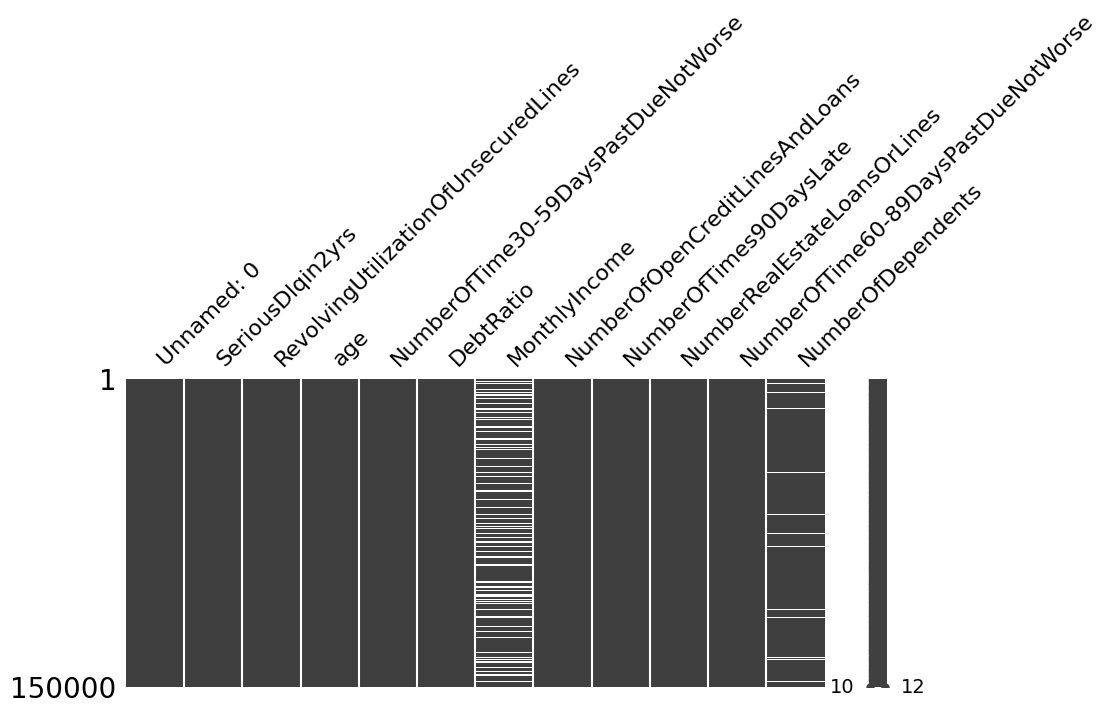

In [30]:
msno.matrix(df, figsize=(10,4))

#Funcion para limpiar datos

Limpieza basica de datos

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin

class BasicCleaner(BaseEstimator, TransformerMixin):
    """Transformaciones básicas: renombrar columnas, log1p en columnas sesgadas, crear indicadores de missing."""
    def __init__(self, log1p_cols=None):
        self.log1p_cols = log1p_cols or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Acepta DataFrame o numpy array (si es numpy, devolvemos idéntico)
        if not isinstance(X, pd.DataFrame):
            return X
        X = X.copy()
        # strip column names
        X.columns = [str(c).strip() for c in X.columns]
        # log1p for selected columns
        for c in self.log1p_cols:
            if c in X.columns:
                X[c] = X[c].where(X[c].isnull(), np.log1p(X[c]))
        # create missing indicators
        for c in X.columns:
            if X[c].isnull().any():
                X[c + '_missing'] = X[c].isnull().astype(int)
        return X

Detección de outliers — IQR e IsolationForest

In [32]:
def iqr_outlier_mask(X, cols, k=1.5):
    mask = pd.Series(False, index=X.index)
    for c in cols:
        q1 = X[c].quantile(0.25)
        q3 = X[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        mask = mask | (X[c] < lower) | (X[c] > upper)
    return mask

Ejemplo IQR mask

In [33]:
num_features = [c for c in num_cols if c in df.columns]

# IQR mask example
mask_iqr = iqr_outlier_mask(df, num_features, k=1.5)
print(f"IQR outliers: {mask_iqr.sum()} rows -> {mask_iqr.mean():.2%}")

IQR outliers: 70937 rows -> 47.29%


Ejemplo IsolationForest

In [34]:
from sklearn.ensemble import IsolationForest

RANDOM_STATE = 42
iso = IsolationForest(contamination=0.01, random_state=RANDOM_STATE)
# rellenamos NAs temporalmente con 0 para el ejemplo de outlier detection
iso_mask = iso.fit_predict(df[num_features].fillna(0)) == -1
print(f"IsolationForest outliers: {iso_mask.sum()} rows -> {iso_mask.mean():.2%}")

IsolationForest outliers: 1500 rows -> 1.00%


# ColumnTransformer + Pipelines

Separación de variables numericas  categoricas

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define feature lists (en este dataset la mayoría son numéricas)
all_features = [c for c in df.columns if c not in [target_col, 'Unnamed: 0']]
num_features = [c for c in all_features if df[c].dtype.kind in 'fi']
cat_features = [c for c in all_features if c not in num_features]

print('num_features:', num_features)
print('cat_features:', cat_features)

num_features: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
cat_features: []


Pipeline con imputador SimpleImputer y se utiliza la mediana para completar los valores faltantes

In [36]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [37]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features)
], remainder='drop')

Ejemplo comparar estrategias de imputación y balanceo (esqueleto)

In [38]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

Ejemplo con class_weight='balanced'

In [39]:
X = df.drop(columns=[target_col, 'Unnamed: 0'] if 'Unnamed: 0' in df.columns else [target_col])
y = df[target_col]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Pipeline con class_weight
pipe_clw = Pipeline([
    ('cleaner', BasicCleaner(log1p_cols=['MonthlyIncome'])),
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE))
])

scores = cross_validate(pipe_clw, X, y, cv=cv, scoring=['roc_auc','average_precision'], n_jobs=-1)
print('LogReg (class_weight) ROC-AUC:', np.mean(scores['test_roc_auc']))
print('LogReg (class_weight) PR-AUC:', np.mean(scores['test_average_precision']))

LogReg (class_weight) ROC-AUC: 0.789145598180486
LogReg (class_weight) PR-AUC: 0.30389723790688106


Pipeline con SMOTE

In [40]:
pipe_smote = ImbPipeline([
        ('cleaner', BasicCleaner(log1p_cols=['MonthlyIncome'])),
        ('pre', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ])

scores_smote = cross_validate(pipe_smote, X, y, cv=cv, scoring=['roc_auc','average_precision'], n_jobs=-1)
print('LogReg + SMOTE ROC-AUC:', np.mean(scores_smote['test_roc_auc']))
print('LogReg + SMOTE PR-AUC:', np.mean(scores_smote['test_average_precision']))

LogReg + SMOTE ROC-AUC: 0.7806427931362456
LogReg + SMOTE PR-AUC: 0.29226926807762044


# Impacto de outlier handling (winsorize vs none)

In [41]:
#Winsorize transform function
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=(0.01, 0.01)):
        self.limits = limits
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # X expected as numpy array or DataFrame with numeric columns in same order as num_features
        X_df = pd.DataFrame(X, columns=num_features)
        Xw = X_df.copy()
        for c in Xw.columns:
            try:
                Xw[c] = mstats.winsorize(Xw[c], limits=self.limits)
            except Exception:
                # si falla (p.ej. por dtype), dejamos la columna igual
                pass
        return Xw.values

Preprocessor con winsorizer

In [42]:
num_pipeline_wins = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('winsor', Winsorizer(limits=(0.01, 0.01))),
    ('scaler', StandardScaler())
])
preprocessor_wins = ColumnTransformer([
    ('num', num_pipeline_wins, num_features)
])

pipe_wins = ImbPipeline([
        ('cleaner', BasicCleaner(log1p_cols=['MonthlyIncome'])),
        ('pre', preprocessor_wins),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ])

scores_wins = cross_validate(pipe_wins, X, y, cv=cv, scoring=['roc_auc','average_precision'], n_jobs=-1)
print('Winsorize + SMOTE ROC-AUC:', np.mean(scores_wins['test_roc_auc']))
print('Winsorize + SMOTE PR-AUC:', np.mean(scores_wins['test_average_precision']))

Winsorize + SMOTE ROC-AUC: 0.7806427931362456
Winsorize + SMOTE PR-AUC: 0.29226926807762044


Preprocessor winsorizer SMOTE

In [43]:
pipe_wins_simple = Pipeline([
        ('cleaner', BasicCleaner(log1p_cols=['MonthlyIncome'])),
        ('pre', preprocessor_wins),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE))
    ])
scores_wins = cross_validate(pipe_wins_simple, X, y, cv=cv, scoring=['roc_auc','average_precision'], n_jobs=-1)
print('Winsorize (sin SMOTE) ROC-AUC:', np.mean(scores_wins['test_roc_auc']))
print('Winsorize (sin SMOTE) PR-AUC:', np.mean(scores_wins['test_average_precision']))

Winsorize (sin SMOTE) ROC-AUC: 0.789145598180486
Winsorize (sin SMOTE) PR-AUC: 0.30389723790688106


Selección final: entrenar en todo el train y evaluar en holdout

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

final_pipe = ImbPipeline([
        ('cleaner', BasicCleaner(log1p_cols=['MonthlyIncome'])),
        ('pre', preprocessor_wins),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])
final_pipe.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
pred_proba = final_pipe.predict_proba(X_hold)[:,1]
print('Holdout ROC-AUC:', roc_auc_score(y_hold, pred_proba))
print('Holdout PR-AUC:', average_precision_score(y_hold, pred_proba))

Holdout ROC-AUC: 0.7928418282744648
Holdout PR-AUC: 0.3105388561495292
